## 1. Imports

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from pathlib import Path
import sys

from seggradcam.dataloaders import Cityscapes
#from seggradcam.metrics import IoU, Dice
from seggradcam.unet import csbd_unet, manual_unet, TrainUnet
from seggradcam.training_write import TrainingParameters, TrainingResults
from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
import matplotlib.pyplot as plt
from seggradcam.visualize_sgc import SegGradCAMplot

sys.path.append(os.path.abspath('../gridsaliency-original'))
from mnist_generators_simple import gen_texture_mnist, plot_samples
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

## Define biased & unbiased configs

In [2]:
N_TRAIN = 50000
N_VAL = 10000
BATCH_SIZE = 20
textures_path = './code/gridsaliency-original/textures/'

unbiased_config = {
    'background_split': 2,
    'dataset_seed': 0,
    'tex_res' : 400,
    'tile_size' : 64,
    'train_samples' : N_TRAIN,
    'test_samples' : N_VAL,
    'exclude_bias_textures': False,
    'fix_test_set': True,
    'batch_size': BATCH_SIZE,
    'bias': None,
    'textures_path' : textures_path,
}
biased_config = {
    'background_split': 2,
    'dataset_seed': 0,
    'tex_res' : 400,
    'tile_size' : 64,
    'train_samples' : N_TRAIN,
    'test_samples' : N_VAL,
    'exclude_bias_textures': True,
    'fix_test_set': True,
    'batch_size': BATCH_SIZE,
    'bias': {2 : {
        "source_1_id": "'feeccd96.png", 
        "source_2_id": "'f135d029.png",
        "source_1_bias": 0.0,
        "source_2_bias": 1.0
    }},
    'textures_path' : textures_path,
}

In [3]:
biased_gen_train = gen_texture_mnist(biased_config,'train', return_dict=False)
biased_gen_test = gen_texture_mnist(biased_config,'test', return_dict=False)

## optionally take a look at the generated samples

Biased Test Set


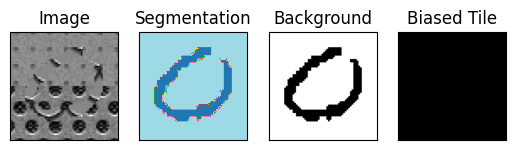

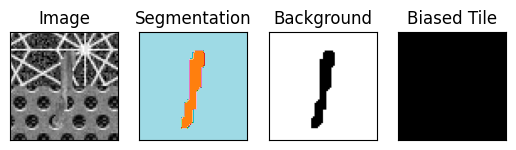

Unbiased Test Set


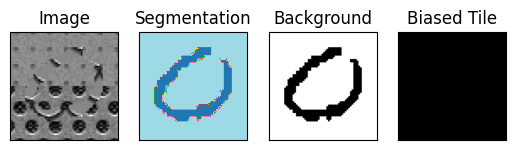

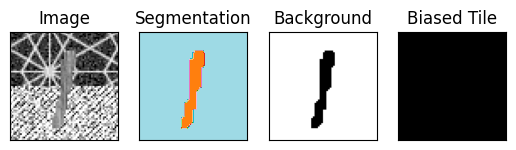

In [4]:

print('Biased Test Set')
biased_generator = gen_texture_mnist(biased_config,'test', return_dict=True)
plot_samples(biased_generator, 2)

print('Unbiased Test Set')
unbiased_generator = gen_texture_mnist(unbiased_config,'test', return_dict=True)
plot_samples(unbiased_generator, 2)

# Option B: load saved model

In [5]:
# Your path:
Path_to_folder = "./output/TexturedMnist/06_24_14_16_fil32_depth4_lr0.0003_scale1_batch100"

trainparam = TrainingParameters(
    dataset_name = 'TexturedMnist',
                 n_classes=11
                ,scale = 1
                ,batch_size = BATCH_SIZE
                ,last_activation = 'softmax'
                ,n_depth = 4
                ,n_filter_base = 32  # 16
                ,pool = 2
                ,lr = 3.e-4
                ,epochs = 200
                ,validation_steps = int(N_VAL/BATCH_SIZE)
                ,steps_per_epoch = int(N_TRAIN/BATCH_SIZE)
                ,loss = "categorical_crossentropy"
                #,optimizer = Adam(lr=3.e-4)
                ,metrics = ['accuracy','iou_coef','dice_coef']
                ,input_shape=(None, None, 1)
                ,n_train= N_TRAIN
                ,n_val = N_VAL
    ,outfolder = Path(Path_to_folder)
)

In [6]:
biased_test_dict = gen_texture_mnist(biased_config,'test', return_dict=True)
next_dict = next(biased_test_dict)
str_folder = str(trainparam.outfolder)
trainunet = TrainUnet(trainparam)
trainunet.csbdUnet()
trainunet.load_weights()
trainunet.model.summary()
trainunet.compile()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 down_level_0_no_0 (Conv2D)     (None, None, None,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   128        ['down_level_0_no_0[0][0]']      
 alization)           

# 3. Seg-Grad-CAM

## 3.1 Set up layers for propagation of gradients

In [7]:
b_necks = trainunet.findBottleneck()
prop_from_layer = trainunet.model.layers[-1].name
prop_to_layer = b_necks[1]
print(prop_to_layer)
prop_to_layer = 'conv2d'

activations in b-neck:  8 , 9
activation_9


## 3.2 Choose an image
We chose a poorly segmented image to demonstrate what was "important" for the U-Net to segment different parts of the image.

In [8]:
cls = 2
imid = cls # id of the image in its batch
image = next_dict[0][imid]

## 3.3 A. Seg-Grad-CAM for a pixel

Shape of self.A: (64, 64, 11)
Shape of self.alpha_c: (11,)
Shape of cam: (64, 64)
Shape of all_cam: (64, 64, 11)


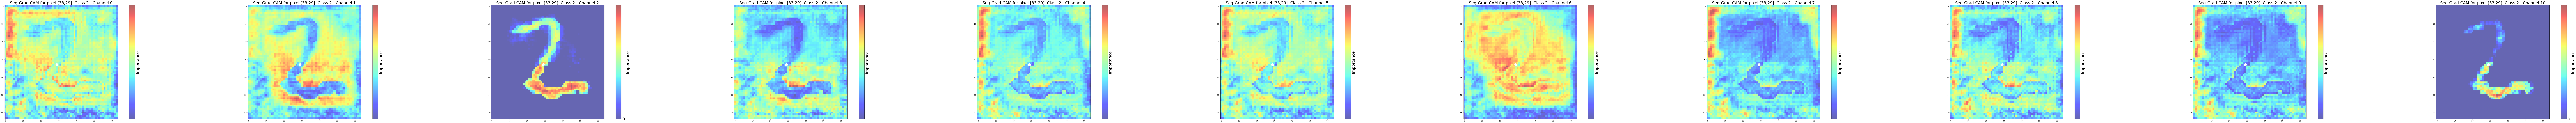

In [9]:
# create a SegGradCAM object
pixsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=PixelRoI(33,29,image),
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc,trainunet,next_dict, imid)
# plot explanations on 1 picture
plotter.explainPixel()

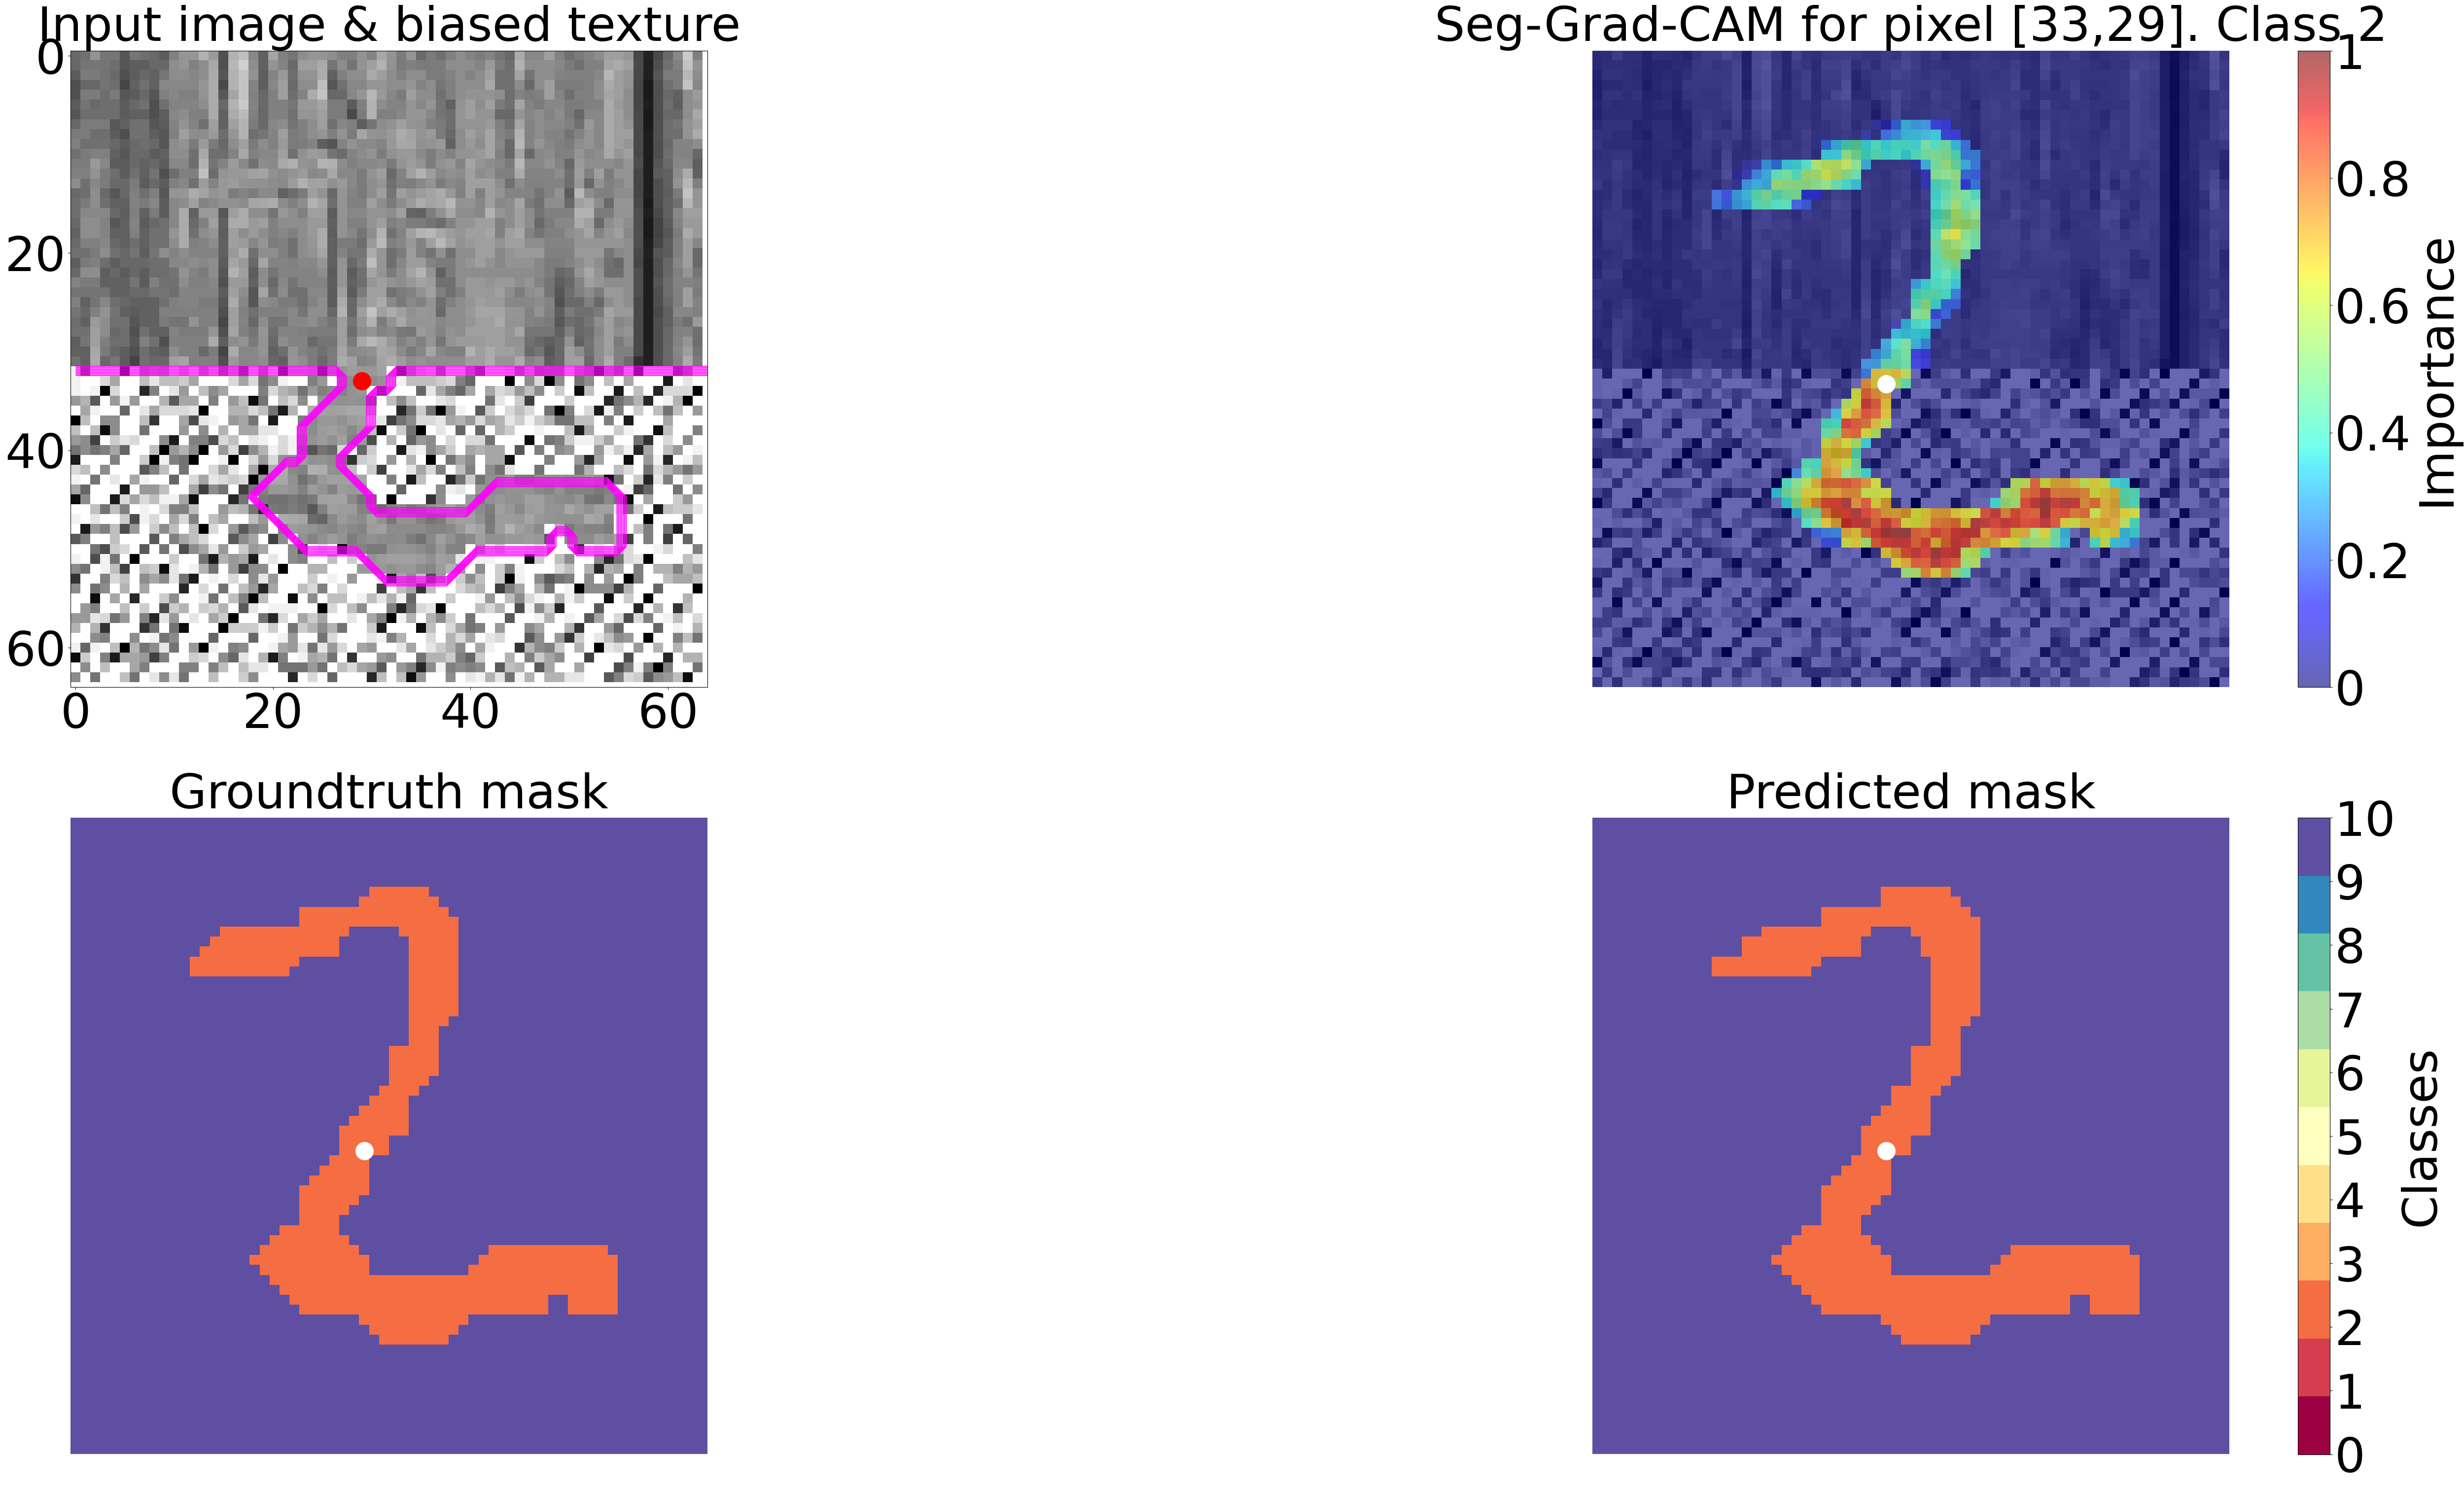

In [10]:
#Plot 4 images: original, ground truth, predicted mask, seg-grad-cam explanations for a selected single pixel
plotter.pixelGtPrediction()

## 3.3 B. Seg-Grad-CAM for the class (all pixels that were predicted as class 'cls')

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 499 499
Shape of self.A: (64, 64, 11)
Shape of self.alpha_c: (11,)
Shape of cam: (64, 64)
Shape of all_cam: (64, 64, 11)


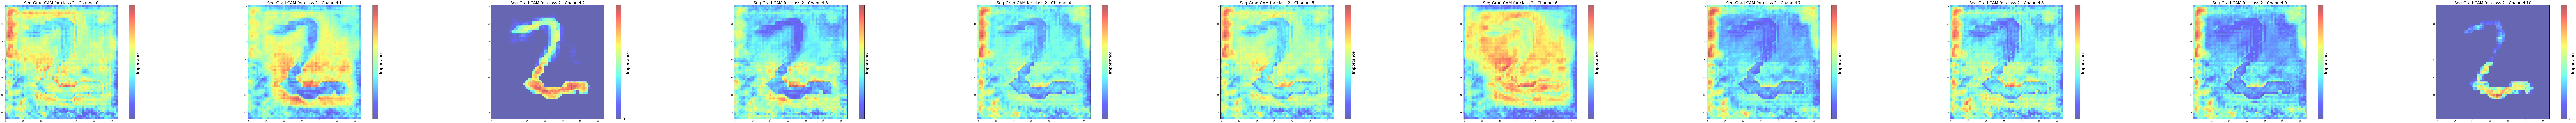

In [11]:
clsroi = ClassRoI(trainunet.model,image,cls)
clssgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc,trainunet,next_dict, imid)
clsplotter.explainClass()

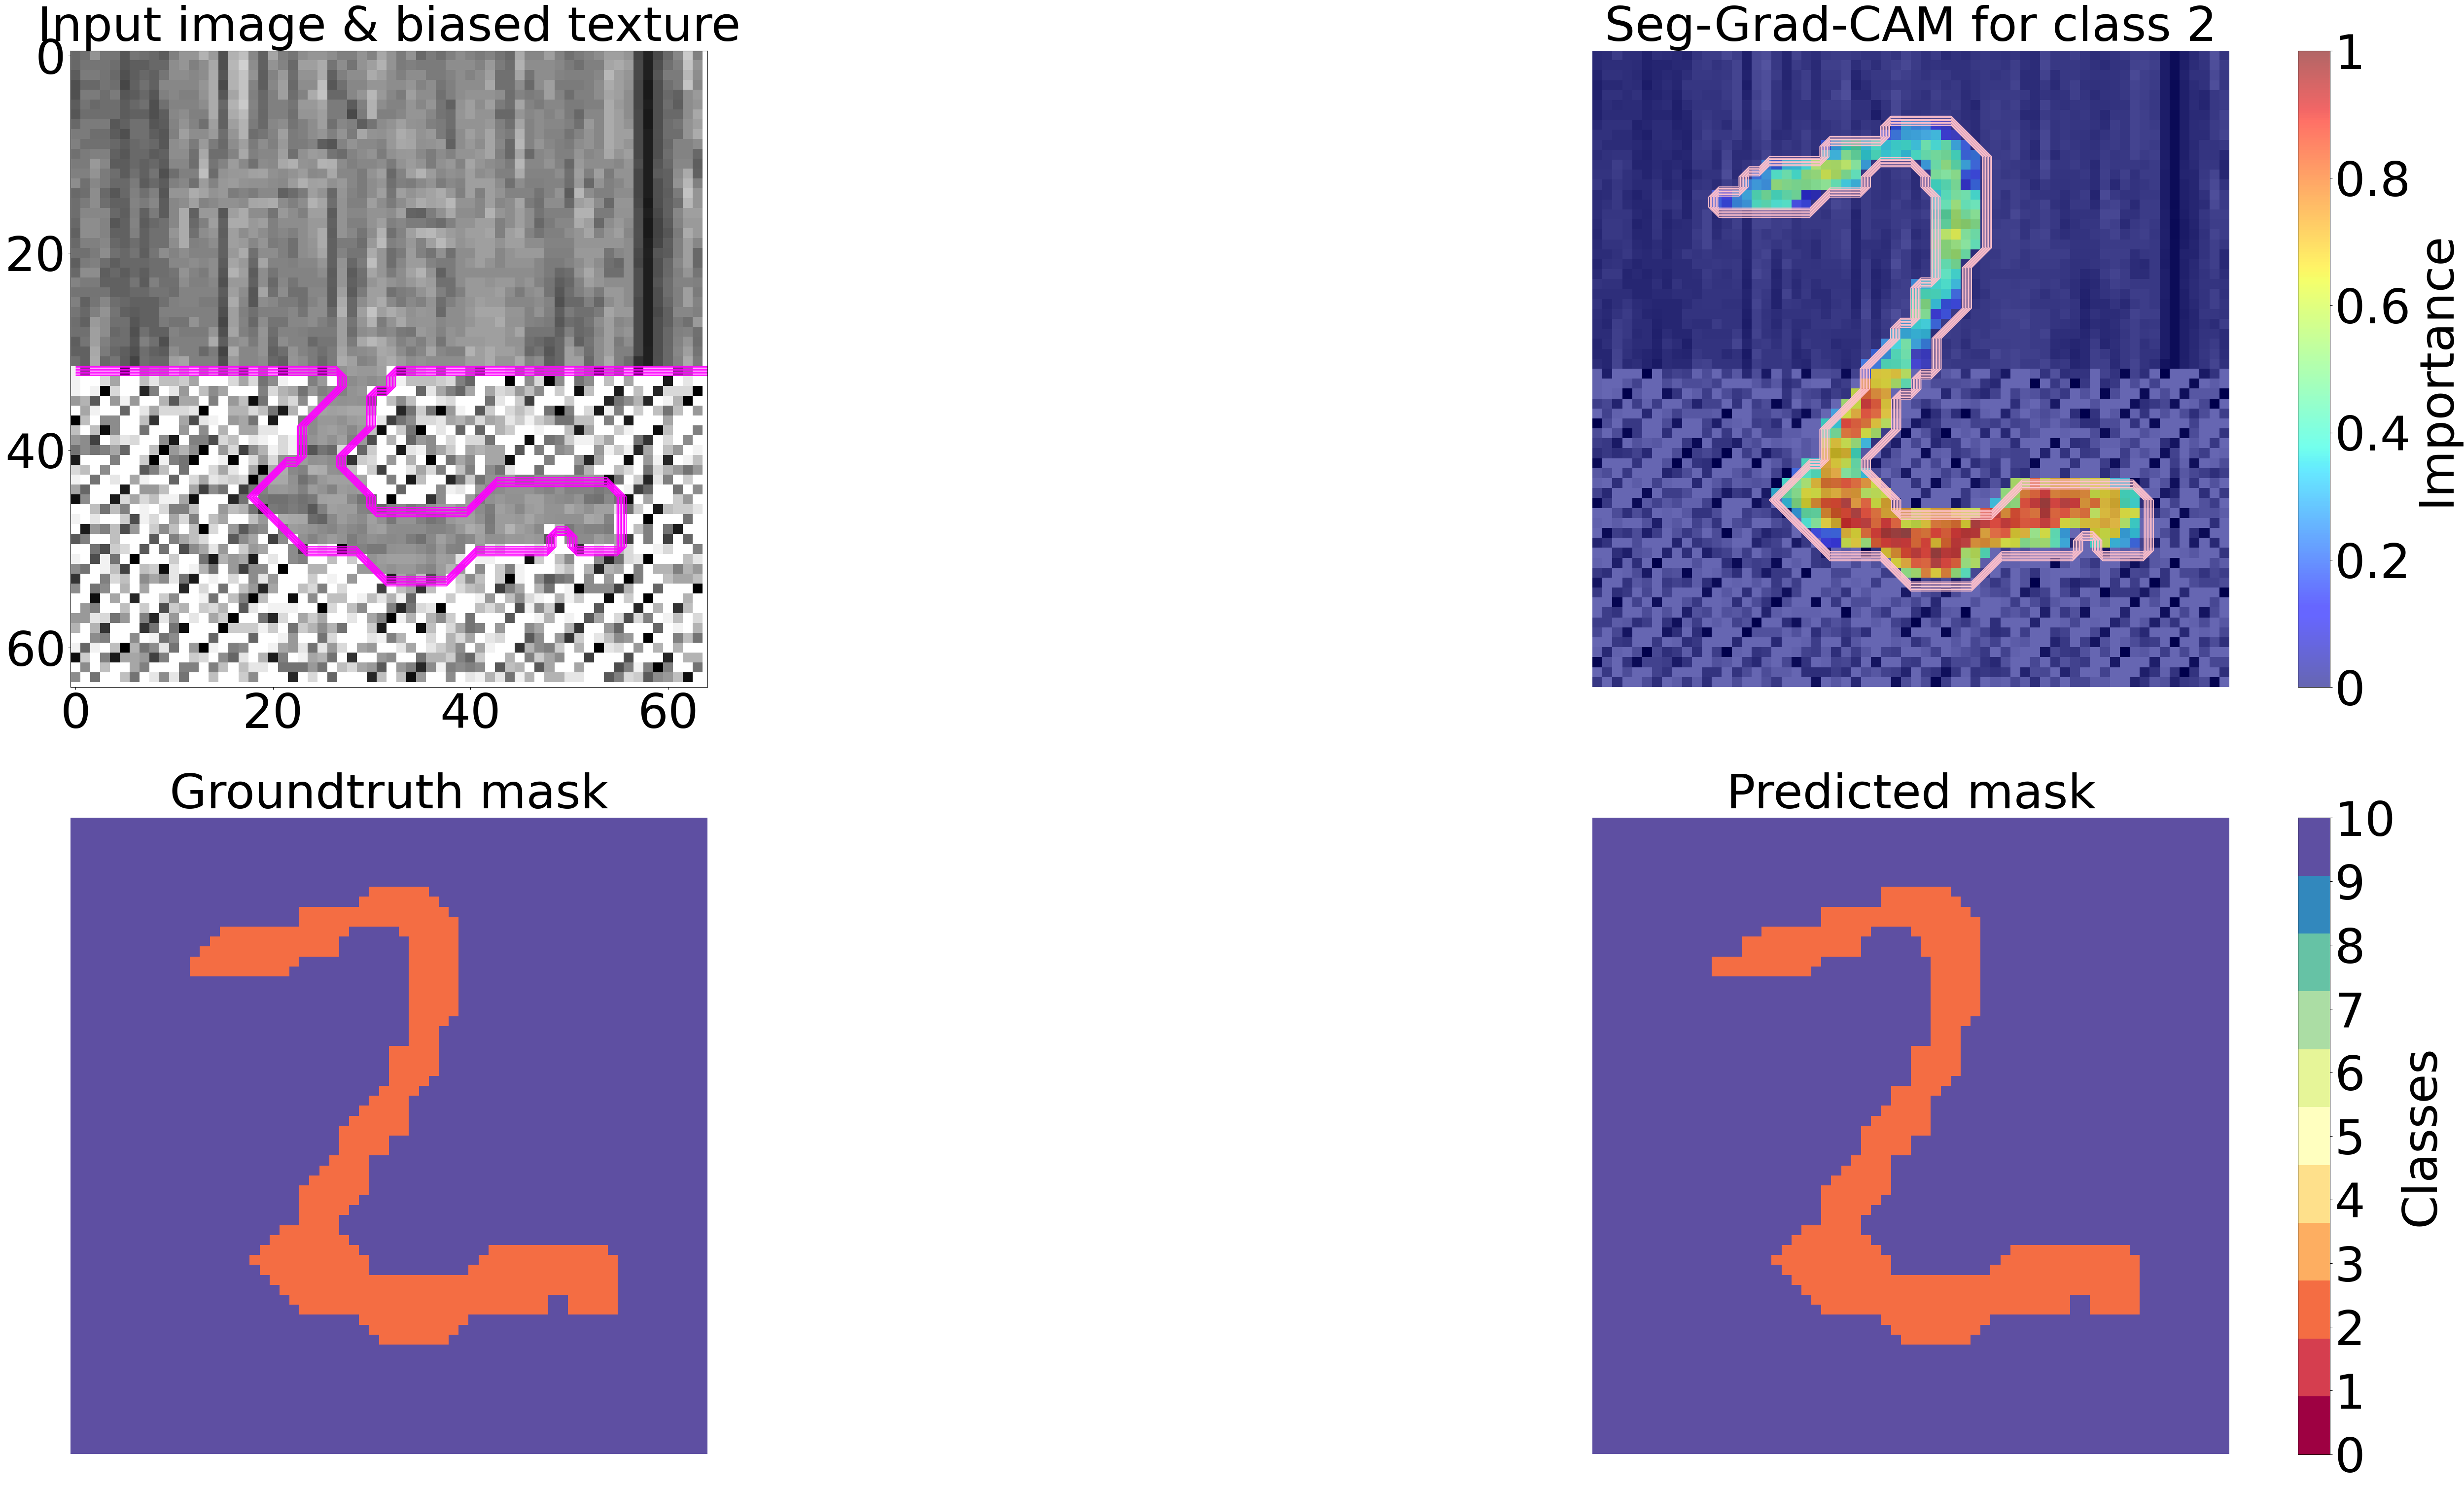

In [12]:
clsplotter.classGtPrediction()

## 3.3 C. Seg-Grad-CAM for a region of interest
### 3.3.C.1 for the largest set of connected pixels predicted as 'cls'

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 499 499
connectedComponents values, counts:  [0 1] [3597  499]
argmax:  1
Shape of RoI:  (64, 64)
Lengths of i and j index lists: 499 499
Shape of self.A: (64, 64, 11)
Shape of self.alpha_c: (11,)
Shape of cam: (64, 64)
Shape of all_cam: (64, 64, 11)


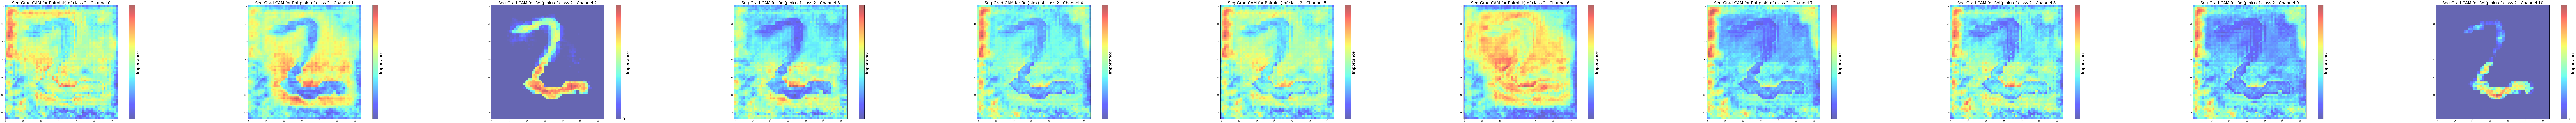

In [13]:
largeroi = ClassRoI(trainunet.model,image,cls)
# find the largest connected component of pixels predicted as 'cls'
largeroi.largestComponent()

largesgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=largeroi,
                 normalize=True, abs_w=False, posit_w=False)
largesgc.SGC()
roiplotter = SegGradCAMplot(largesgc,trainunet,next_dict, imid)
roiplotter.explainRoi()

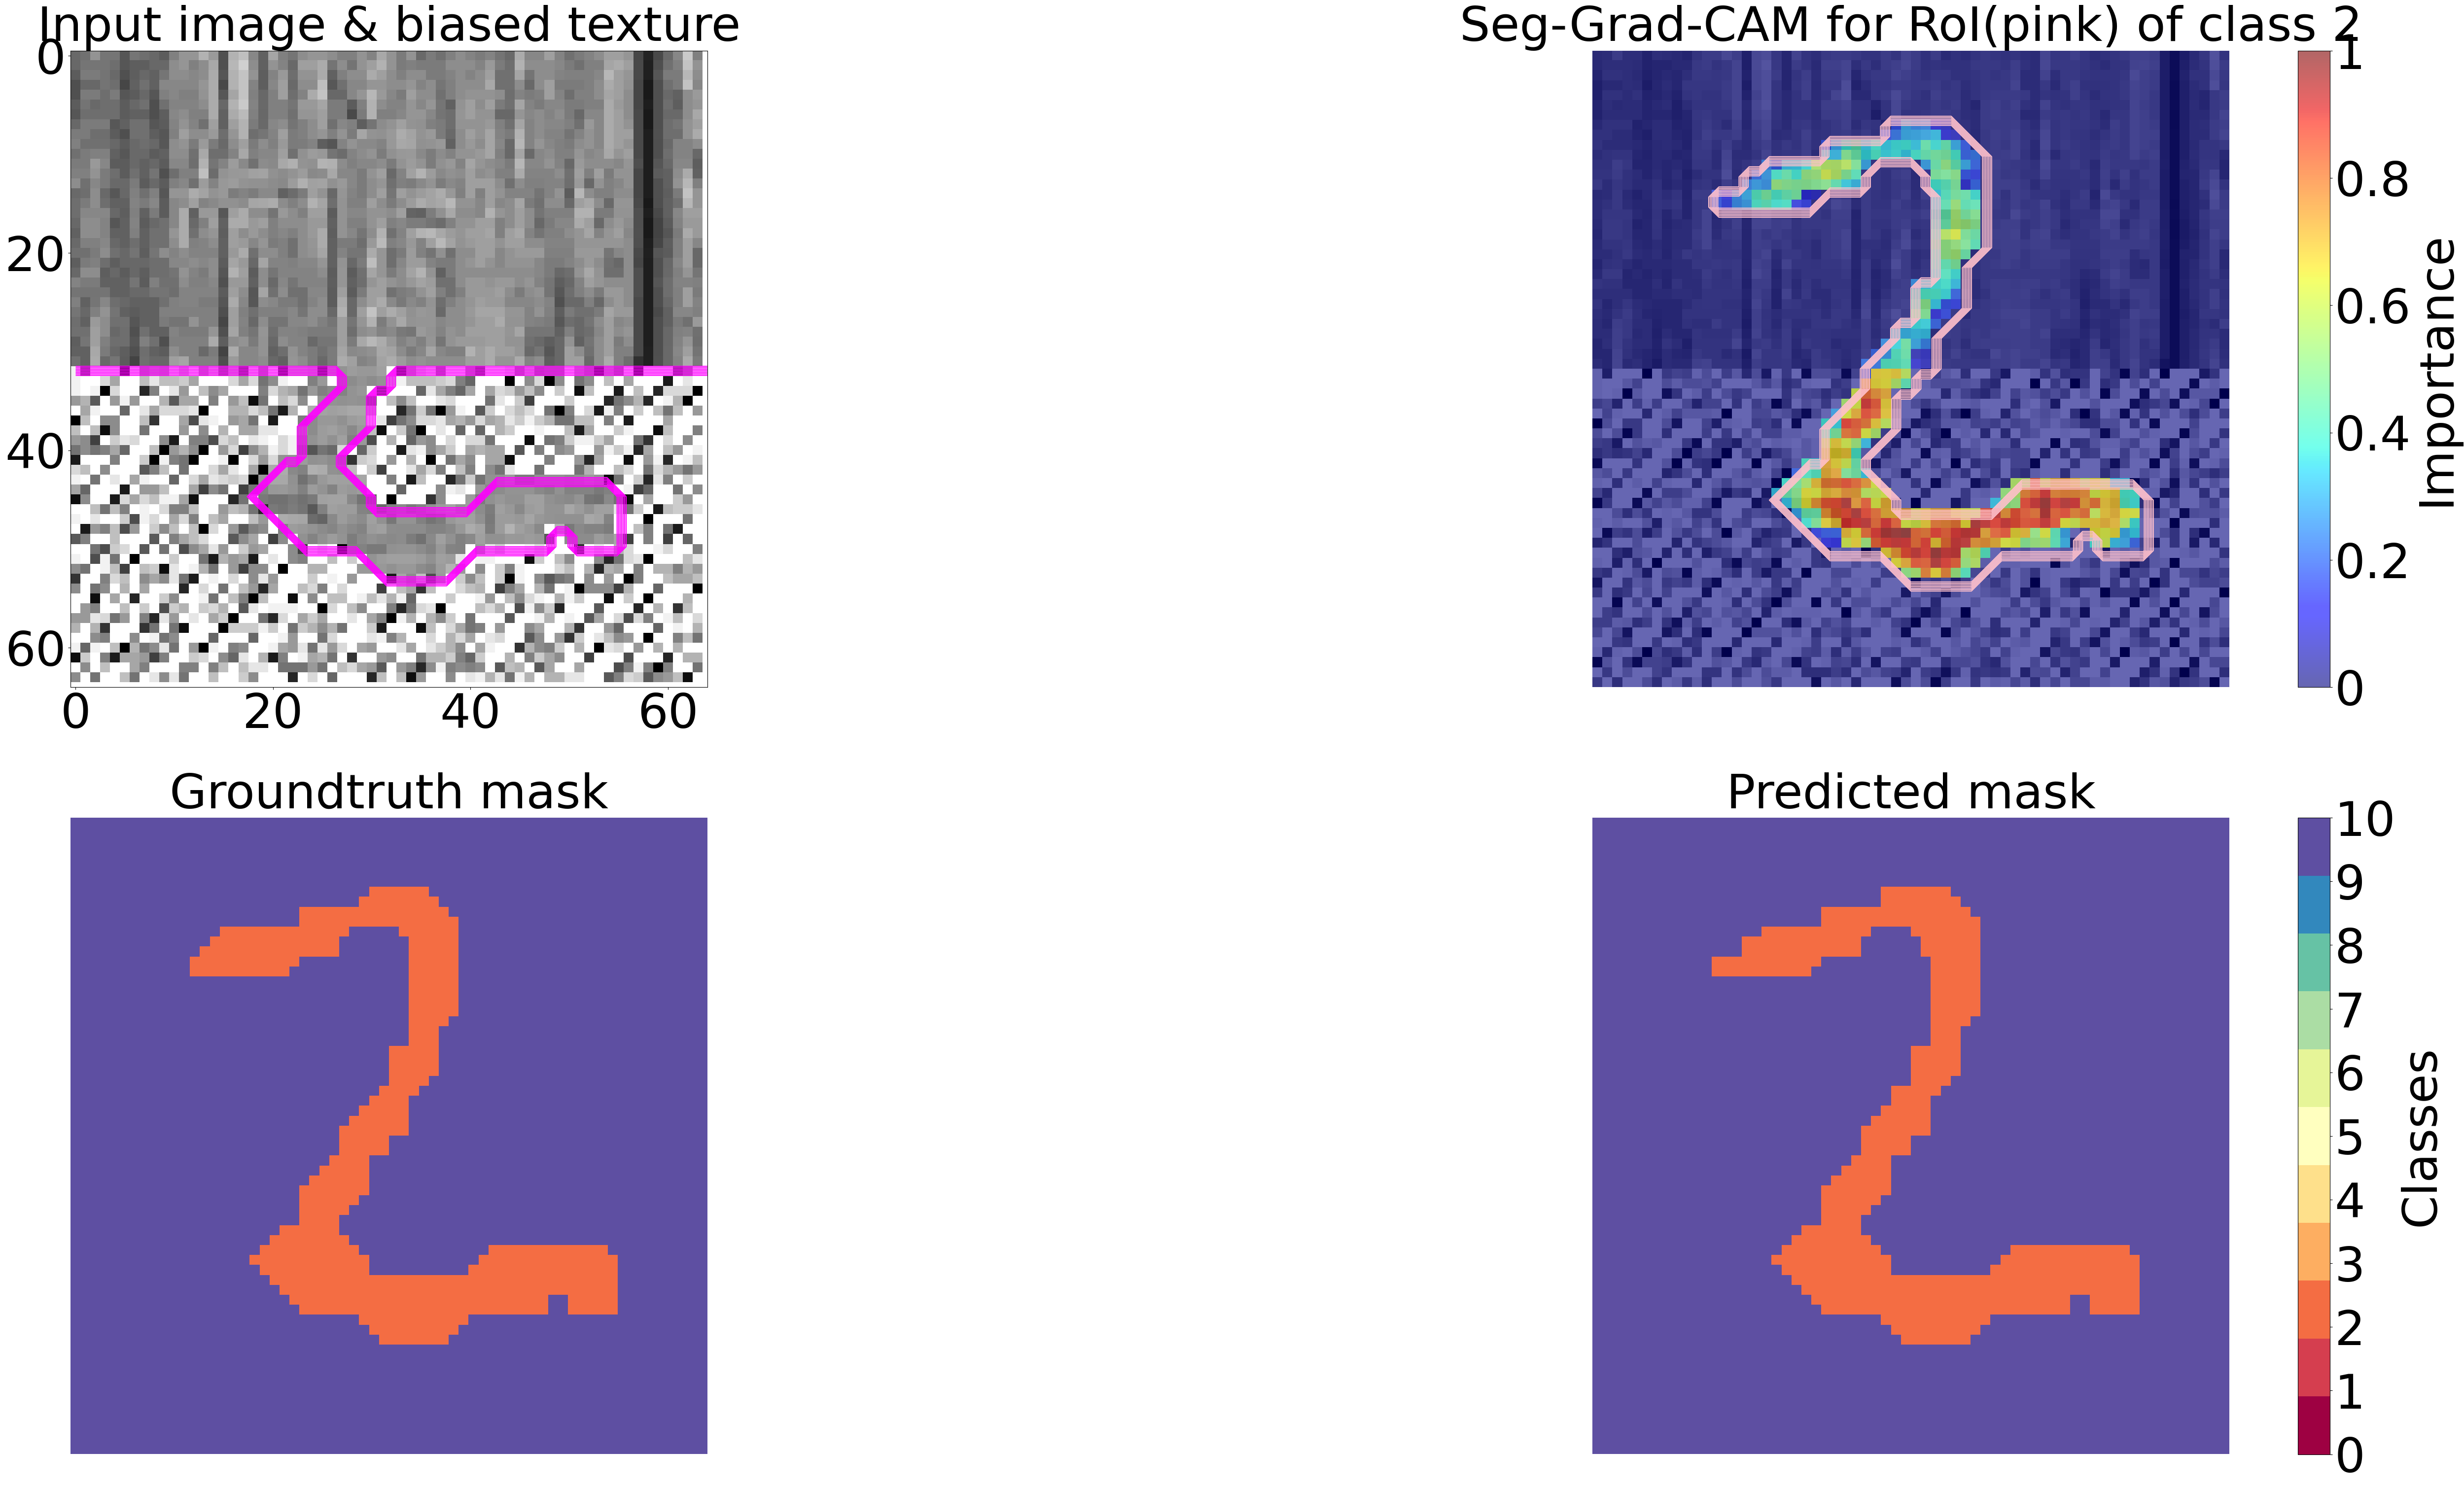

In [14]:
roiplotter.roiGtPrediction()

### 3.3.C.2 for the smallest set of connected pixels predicted as 'cls'

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 499 499
connectedComponents values, counts:  [0 1] [3597  499]
argmin:  1
Shape of RoI:  (64, 64)
Lengths of i and j index lists: 499 499
Shape of self.A: (64, 64, 11)
Shape of self.alpha_c: (11,)
Shape of cam: (64, 64)
Shape of all_cam: (64, 64, 11)


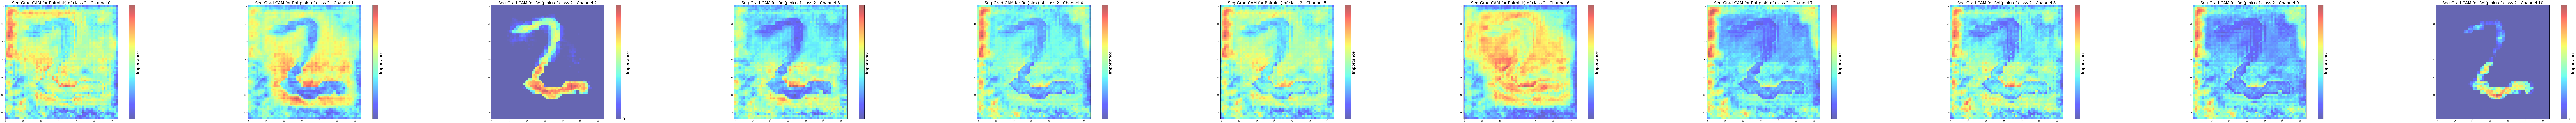

In [15]:
smallroi = ClassRoI(trainunet.model,image,cls)
# Now, for the smallest component
smallroi.smallestComponent()

smallsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=smallroi,
                 normalize=True, abs_w=False, posit_w=False)
smallsgc.SGC()
smallroiplotter = SegGradCAMplot(smallsgc,trainunet,next_dict, imid)
smallroiplotter.explainRoi()

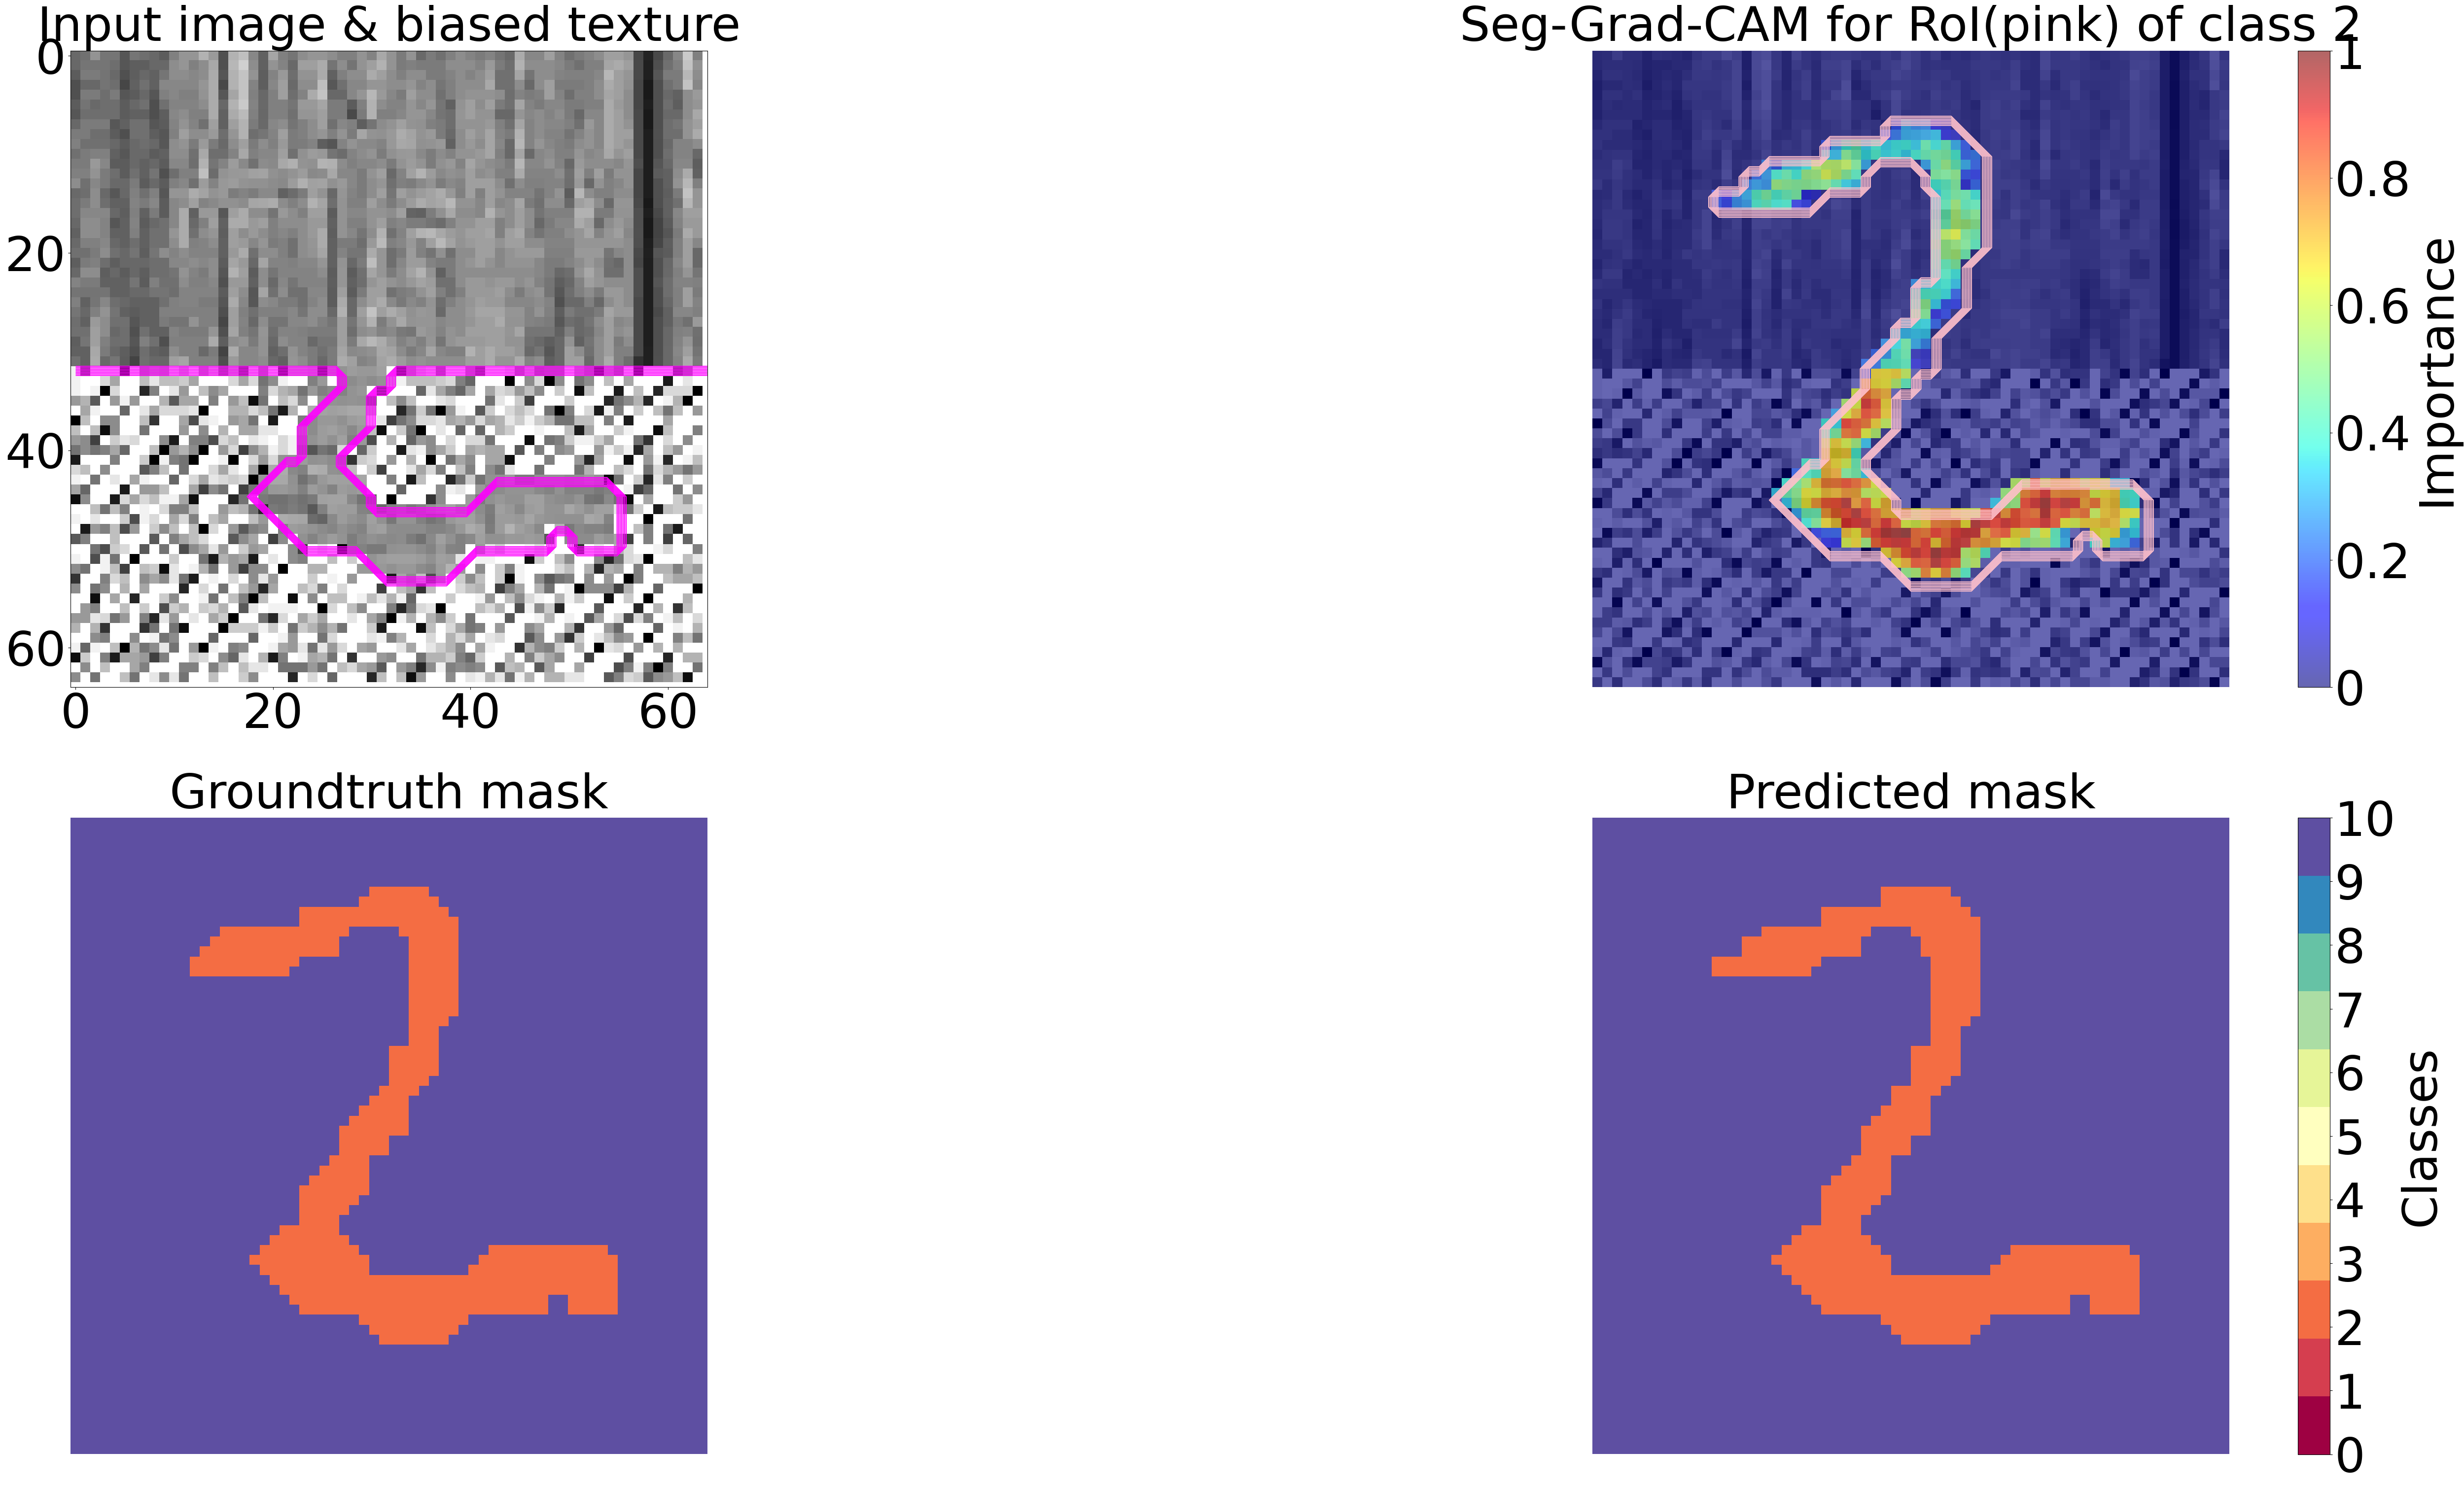

In [16]:
smallroiplotter.roiGtPrediction()